In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import BertTokenizerFast
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from langchain.embeddings import HuggingFaceEmbeddings
from torch.utils.data import Dataset, DataLoader
import lightning as pl
import torch
from torch import nn
from torch.functional import F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
from copy import copy
import string
from sklearn.metrics import f1_score, balanced_accuracy_score
from pathlib import Path
import spacy

torch.set_float32_matmul_precision('medium')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stephan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Introduction (Alex)

## Why we need text classification

## Approaches
- Classic machine learning (baseline)
- RNN Deep-learning
- Transformers

## Evaluation

How do we evaluate the systems

### Quantitative evaluation

#### F1-Macro
Why we choose this / Why is this metric suited

#### Accuracy
Why we choose this / Why is this metric suited

### Qualitative evaluation
Examples on individual samples from test split and final comparison of model performane on a custom benchmark.


# Dataset (Tobias)

The dataset crafted for the chatbot merges three distinct types of data to cover a range of interactions it will encounter. From the [germanquad](https://huggingface.co/datasets/deepset/germanquad) dataset, questions are selected for their relevance to general knowledge inquiries. These are paired with texts from the [germeval18](https://huggingface.co/datasets/philschmid/germeval18) dataset, which provides examples of offensive language that the chatbot must learn to recognize and reject. To add depth, the dataset includes concern-related texts, which are sourced from the [Stress-Annotated Dataset (SAD)](https://github.com/PervasiveWellbeingTech/Stress-Annotated-Dataset-SAD) that contains English-language entries pertaining to stressors in areas such as school and work. These entries are translated into German to align with the rest of the dataset, ensuring the chatbot receives uniform input during training. For translation, a [model](https://huggingface.co/facebook/nllb-200-distilled-1.3B) from Hugging Face is used.

The purpose of a balanced training and testing set is to create a chatbot that can handle all types of prompts equally well. By having an equal number of questions, concerns, and examples of harmful content, the chatbot is less likely to become biased. It won't over-prioritize one type of prompt over another. This balance is important because it reflects the variety of inputs a chatbot will encounter once it goes live. 

## Explorative Data Analysis

In [31]:
df_train = pd.read_parquet("data/train.parquet")
df_test = pd.read_parquet("data/test.parquet")

### Class balance 

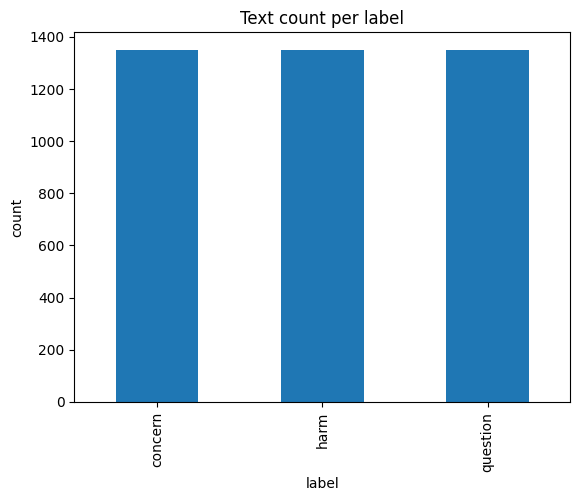

In [32]:
df_train.groupby("label").size().plot.bar()
plt.xlabel("label")
plt.ylabel("count")
plt.title("Text count per label")
plt.show()

As we can see the [build_dataset.py](build_dataset.py) handled the class balancing correctly.  
There is no class imbalance.

### Duplicates and intersection between train and test

In [33]:
print("Duplicates in train df: ", df_train.text.duplicated().sum())
print("Duplicates in test df: ", df_test.text.duplicated().sum())

print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
print("Length of train set: ", len(df_train))
print("Length of test set: ", len(df_test))

Duplicates in train df:  9
Duplicates in test df:  1
Intersection between train and test:  4
Length of train set:  4050
Length of test set:  1014


As we can see we have duplicates in the dataset.  
There are also some texts in the train and test dataset simultaneously.  
The amount of intersections and duplicates is low but for the sake of completeness they are removed.

In [34]:
#drop duplicates
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

#drop intersections from test set
df_test.drop(df_test[df_test.text.isin(np.intersect1d(df_train.text.values, df_test.text.values))].index, inplace=True)

In [35]:
print("Duplicates in train df: ", df_train.text.duplicated().sum())
print("Duplicates in test df: ", df_test.text.duplicated().sum())

print("Intersection between train and test: ", len(np.intersect1d(df_train.text.values, df_test.text.values)))
print("Length of train set: ", len(df_train))
print("Length of test set: ", len(df_test))

Duplicates in train df:  0
Duplicates in test df:  0
Intersection between train and test:  0
Length of train set:  4041
Length of test set:  1009


After removal no duplicates or intersections occured.

### Distribution of word count

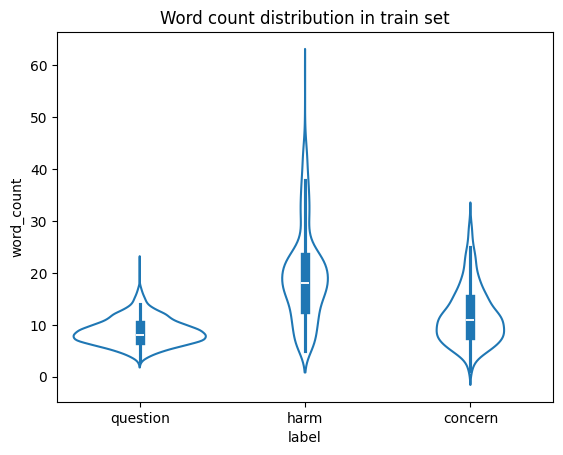

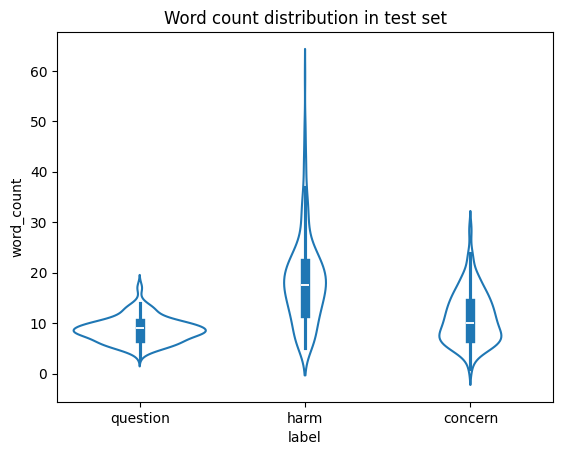

In [37]:
sns.violinplot(df_train.assign(word_count=df_train['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in train set")
plt.show()

sns.violinplot(df_test.assign(word_count=df_test['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Word count distribution in test set")
plt.show()

In these violin plots we can see the word count distribution of the texts grouped by class.  
Harm has the longest median word count per text with a massive tail.  
Question has the smallest variance in word count compared to harm and concern.

### Qualitative 

In [38]:
for label, df in df_train.groupby("label"):
    print(label + ":")
    display(df.sample(10, random_state=1).text.to_list())

concern:


['Ich werde sehr müde von der scharfen Art, wie sie uns an unseren Jobs anpassen wollen.',
 'Ja, ich hatte harte Zeiten. Ich hatte mit einem alkoholischen, missbräuchlichen Vater zu tun.',
 'Ich habe meinen Job verloren, also weiß ich nicht, wie die Miete bezahlt wird.',
 'Ich arbeite wegen Covid nicht, also fühlt sich alles stressig an.',
 'Ich mache mir Sorgen um meine Eltern, habe seit 2 Wochen nicht mit meinem Dad gesprochen.',
 'Ich kann nicht mit der Krankheit meines kleinen Bruders umgehen.',
 'Außerdem bin ich sehr deprimiert und fühle mich gestresst wegen der Arbeit und der Suche nach einem neuen Job.',
 'Danke für die Frage. Zu viel Arbeit und so wenig Zeit.',
 'Meine Noten und einen Kurs, den ich im Moment nicht mehr bewältigen kann.',
 'Mein Vorgesetzter drängt mich derzeit sehr, Berichte einzureichen.']

harm:


['Hubertus....was hab ich mit Adolf zu tun? LBR Und ich erstarre bei beim Wort Nazi auch nicht in Schuldgefühlen wie der Rest nur weil ichliebe',
 'Politiker gleichbedeutend mit BERUFSLÜGNER richten gerade irreparable Schäden für unser Land Europa und die Welt an und Mio schauen zu ',
 'Sie Gabriel und Merkel mit ihrem antirussischen Gelaber und ihrer MassenIslamisierung bringen uns in Kriegsgefahr!',
 'Wenn die Grünen Stinktiere in Deutschland verschwinden im September wird Deutschlands Luft enorm besser werden!',
 'Das ist die Vorankündigung der Merkel Vasallen wie den Bürger noch mehr Geld aus der Tasche gezogen werden soll um die Flüchtlinge zu finan.',
 'Türken die sich die österreichische Staatsbürgerschaft erschlichen haben LBR müssen aufgedeckt und verurteil werden. Davonjagen.',
 'Dem Kommentar entnehme ich das auch ihre Schaukel als Kind zu nahe an der Wand gestanden hat.',
 'Was ist denn mit unseren Generälen los ??Bei dem UNRECHTSSYSTEM wäre doch mal ein Militärputsch schön

question:


['An wessen Geschichte ist der Film Dreamgirls angelehnt?',
 'Welche Rolle spielen Indizes bei der Abfrageoptimierung in Datenbanksystemen?',
 'Mit wem hatte Madonna ihr erste Tochter?',
 'Wie viele Menschen in den USA sind jüdischen Glaubens?',
 'Wie kann man Jagd- von Tiermalerei unterscheiden?',
 'Aus welchen Teilen besteht die Uniform der Spieler im Canadian Football?',
 'Für welche Katastrophe öffnete die Sowjetunion das erste mal die Grenzen für internationale Hilfe? ',
 'Mit welchem Grund lehnte man die Rechtschreibung von Siegenbeek in Belgien ab? ',
 'Was brauchen Hunde um Farben sehen zu können?',
 'Welche Bakterien bilden Flagellen?']

### Wordcloud

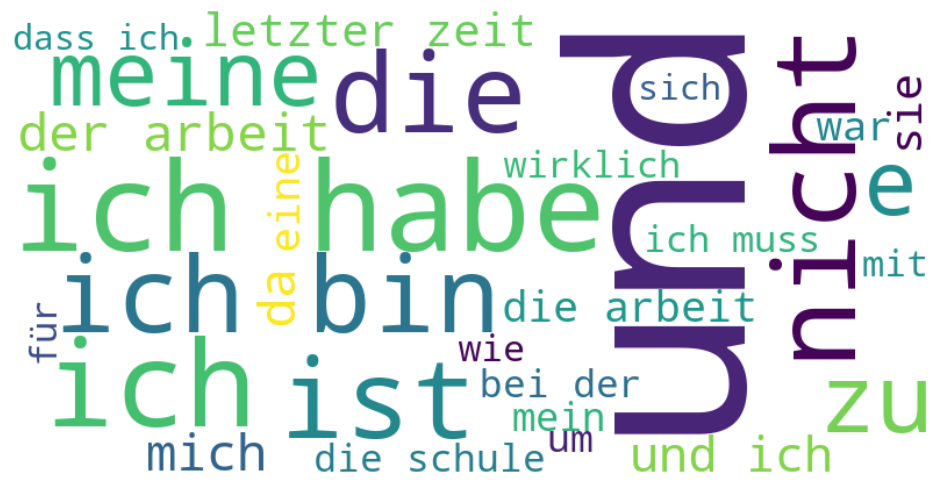

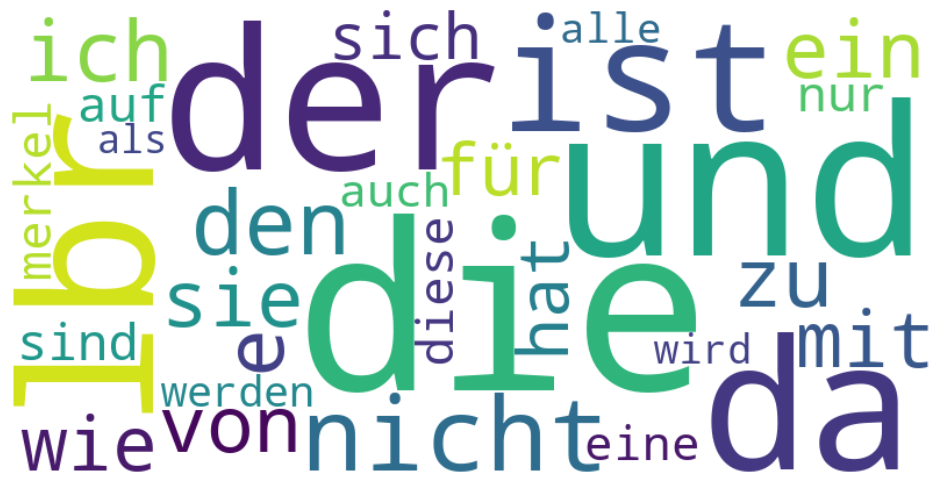

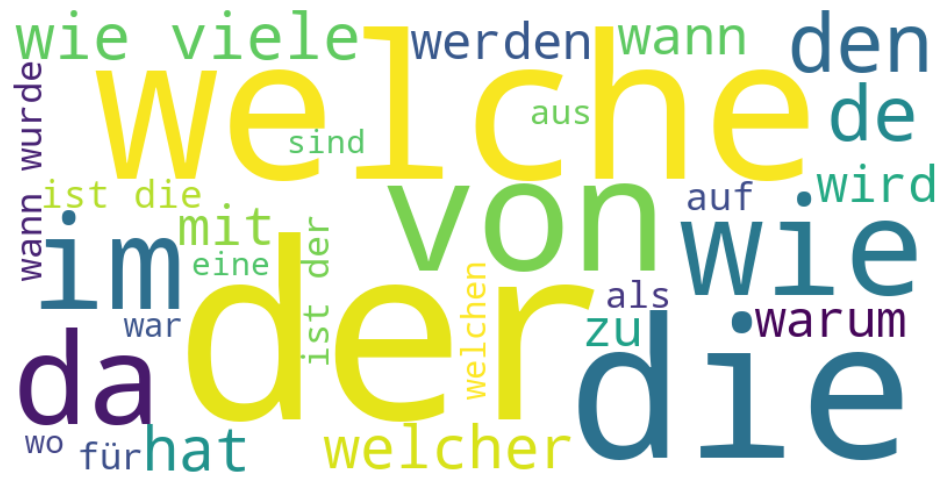

In [51]:
#!python -m spacy download de_core_news_sm

def generate_count_wordclouds(df:pd.DataFrame, top_n_words=30):
    nlp = spacy.load("de_core_news_sm")

    # create custom tokenizer that removes punctuation, spaces and non-alphabetic characters
    def spacy_tokenizer(doc):
        with nlp.disable_pipes(*["ner", "parser", "tagger"]):
            return [t for t in nlp(doc) if not t.is_punct and not t.is_space]

    for label, df in df.groupby("label"):
        tokens = df.text.apply(spacy_tokenizer)
        lowercase_tokens = [token.lower_ for doc in tokens for token in doc]

        # create wordcloud
        wordcloud = WordCloud(
            width=800, height=400, background_color="white", max_words=top_n_words
        ).generate(" ".join(lowercase_tokens))

        # show wordcloud
        plt.figure(figsize=(12, 10))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()


generate_count_wordclouds(df_train)

# Approach #1: TF-IDF / SVM (Alex)
Introduction?

## Model Architecture
Visualization

## Why we chose this architecture
Why is this architecture suited for this task? Possible drawbacks? Advantages?

In [ ]:
#TODO Training / Quantitative evaluation / qualitative evaluation

## Results
Model results / How could model be improved

# Approach #2: LSTM (Tobias)
Introduction?

## Model Architecture
Visualization

## Why we chose this architecture
Why is this architecture suited for this task? Possible drawbacks? Advantages?

In [ ]:
#TODO Training / Quantitative evaluation / qualitative evaluation

## Results
Model results / How could model be improved

# Approach #3: BERT (Yvo)
Introduction?

## Model Architecture
Visualization

## Why we chose this architecture
Why is this architecture suited for this task? Possible drawbacks? Advantages?

In [ ]:
#TODO Training / Quantitative evaluation / qualitative evaluation

## Results
Model results / How could model be improved

# Benchmark on custom dataset (Yvo)

In [ ]:
#TODO run all models on this dataset

## Discussion

How did the models perform on the custom dataset

In [2]:
df_train = pd.read_parquet("data/train.parquet")
df_test = pd.read_parquet("data/test.parquet")

In [3]:
df_train

,text,label
0,Unter welcher Bedingung ist nach der Powell-D...,question
1,Wo wird Uran als Energiequelle eingesetzt?,question
2,Wer wurde im Jahr 2010 Ehrenbürgerin von Paris?,question
3,Mit welchen Universitäten steht die University...,question
4,Wo auf der Erde ist am meisten Wasser gespeich...,question
...,...,...
4045,Jetzt muss ich für meine Abschlussprüfungen le...,concern
4046,Ich habe die ganze Woche mit Personalproblemen...,concern
4047,"Die Schule war so hart, ich kann nicht mithalten.",concern
4048,"Gott weiß, dass meine Eltern mich nicht wollen.",concern


# EDA

## Verteilung der Klassen und Anzahl Wörter

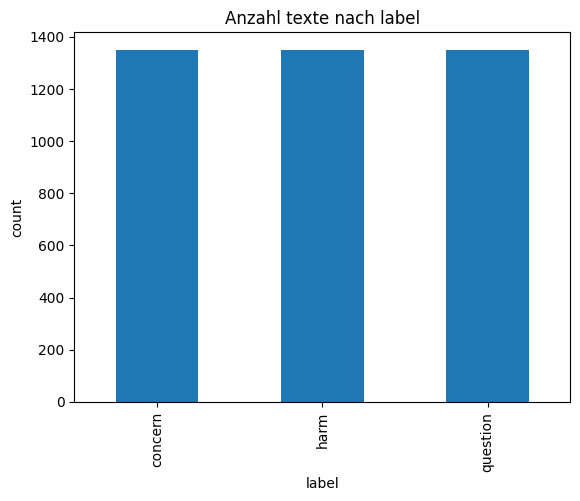

In [71]:
df_train.groupby("label").size().plot.bar()
plt.xlabel("label")
plt.ylabel("count")
plt.title("Anzahl texte nach label")
plt.show()

In diesem Plot ist zu erkennen, dass jede Gruppe (label) im train-set gleich vertreten ist.

In [72]:
df_train

,text,label
0,Unter welcher Bedingung ist nach der Powell-D...,question
1,Wo wird Uran als Energiequelle eingesetzt?,question
2,Wer wurde im Jahr 2010 Ehrenbürgerin von Paris?,question
3,Mit welchen Universitäten steht die University...,question
4,Wo auf der Erde ist am meisten Wasser gespeich...,question
...,...,...
4045,Jetzt muss ich für meine Abschlussprüfungen le...,concern
4046,Ich habe die ganze Woche mit Personalproblemen...,concern
4047,"Die Schule war so hart, ich kann nicht mithalten.",concern
4048,"Gott weiß, dass meine Eltern mich nicht wollen.",concern


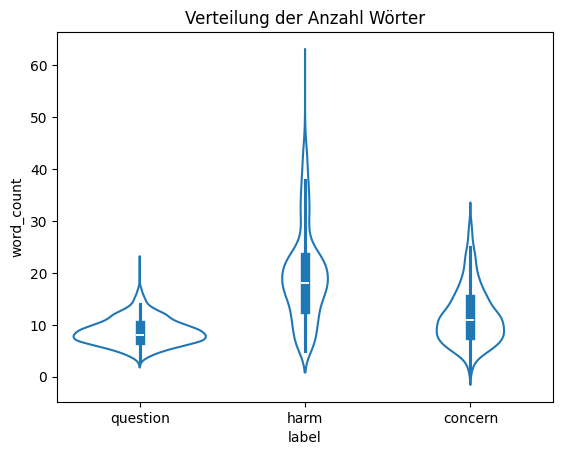

In [73]:
sns.violinplot(df_train.assign(word_count=df_train['text'].apply(lambda x: len(x.split(" "))))[["label", "word_count"]], x="label", y="word_count", fill=False) 
plt.title("Verteilung der Anzahl Wörter")
plt.show()

Um herauszufinden, wie die Wortverteilung pro Klasse aussieht, wurde jeweils die Anzahl Wörter im Text gezählt und anschliessend ein Violinplot visualisiert.<br>
Dieser Plot zeigt, dass die Verteilung nach Klasse seht unterschiedlich ist.<br>
Auffällig ist der lange Schwanz bei `harm`.<br>

## Duplikate?

In [90]:
print(df_train.text.duplicated().value_counts())
print(df_test.text.duplicated().value_counts())

print("number of intersects between train and test", len(np.intersect1d(df_train.text.values, df_test.text.values)))

text
False    4041
True        9
Name: count, dtype: int64
text
False    1013
True        1
Name: count, dtype: int64
number of intersects between train and test 4


Es gibt ein paar Duplikate.<br>
Allerdings sind es so wenig, dass kein weiteres cleaning nötig ist.<br>
Die Intersections sind 

## Text qualitative

In [75]:
for label, df in df_train.groupby("label"):
    print(label + ":")
    display(df.sample(10, random_state=1).text.to_list())

concern:


['Ich sollte dieses Wochenende nutzen, um für die Prüfung zu lernen, die ich nochmal machen muss.',
 'Meine Arbeit behandelt mich in letzter Zeit schrecklich, und es scheint, als würde ich einfach meine Zeit verschwenden.',
 'Heute war die Arbeit sehr nervös.',
 'Ich werde bald meinen Job wechseln und ich bin nervös darüber.',
 'Ich beschwere mich über meinen Job und meinen Mangel an einem netteren.',
 'Ich bin gestresst, weil es schwer ist, zu arbeiten, wenn man bipolar ist.',
 'Es war eine harte Woche bei der Arbeit!',
 'Als ich nach Hause kam, war ich wieder gestresst.',
 'Die Arbeit ist stressig und ich plane die Hochzeit im nächsten Jahr!',
 'Mom ist immer noch sauer aus irgendeinem Grund... habe seit einiger Zeit nicht mit meinen Freunden gesprochen... ich muss arbeiten.']

harm:


['Hubertus....was hab ich mit Adolf zu tun? LBR Und ich erstarre bei beim Wort Nazi auch nicht in Schuldgefühlen wie der Rest nur weil ichliebe',
 'Politiker gleichbedeutend mit BERUFSLGNER richten gerade irreparable Schäden für unser Land Europa und die Welt an und Mio schauen zu ',
 'Sie Gabriel und Merkel mit ihrem antirussischen Gelaber und ihrer MassenIslamisierung bringen uns in Kriegsgefahr!',
 'Wenn die Grünen Stinktiere in Deutschland verschwinden im September wird Deutschlands Luft enorm besser werden!',
 'Das ist die Vorankündigung der Merkel Vasallen wie den Bürger noch mehr Geld aus der Tasche gezogen werden soll um die Flüchtlinge zu finan.',
 'Türken die sich die österreichische Staatsbürgerschaft erschlichen haben LBR müssen aufgedeckt und verurteil werden. Davonjagen.',
 'Dem Kommentar entnehme ich das auch ihre Schaukel als Kind zu nahe an der Wand gestanden hat.',
 'Was ist denn mit unseren Generälen los ??Bei dem UNRECHTSSYSTEM wäre doch mal ein Militärputsch schön 

question:


['Welche Rolle spielen Indizes bei der Abfrageoptimierung in Datenbanksystemen?',
 'Zu welcher Sprachfamilie gehört Tigrinya?',
 'Wann spricht man von altiranischen Sprachen?',
 'Wann bildeten sich Siedlungen auf der Ile de la Cite in Paris?',
 'Wann wurde der Stone of Scone aus der Westminister Abbey geklaut?',
 'Als was gilt die Unterscheidung von Materie und Bewusstsein?',
 'Welche Vögel sind in Ägypten weit verbreitet?',
 'Mit welchem Grund lehnte man die Rechtschreibung von Siegenbeek in Belgien ab? ',
 'Wer ist der Generalgouverneur von Tuvalu?',
 'Was unterscheidet die Kleidung der verschiedenen Klassen im Mittealter? ']

Wie man erkennen kann, sind die Klassen `concern` und `question` auf diesen Beispielen grammatikalisch Korrekt.<br>
Die Klasse `harm` allerdings hat einige Fehler:
- Leerschläge wurden vergessen
- grammatikalische Fehler
- repetitionen von Satzzeichen

## Tokenization

In [4]:
# Erstellen Sie einen neuen WordPiece-Tokenizer
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Erstellen Sie einen neuen WordPiece-Trainer
trainer = WordPieceTrainer(
    special_tokens=["[UNK]"],
)

#train
tokenizer.train_from_iterator(df_train.text.tolist(), trainer)

Damit nicht jedes Wort mit all seinen möglichen Variationen als einzelne Tokens abgespeichert werden müssen, verwenden wir nun den WordPiece Tokenizer.<br>
Statt ein ganzes Wort einem Token zuzuweisen, spaltet er möglicherweise ein Wort in Wortstücke (Wordpieces) auf, wobei immer das erste Subword normal und die anschliessenden Subwords mit einem `##` Prefix versehen sind.<br>
Dies hat den Vorteil, dass eine seltene Wortkombination trotzdem Tokenisiert werden kann und nicht ein `[UNK]` Token verwendet werden muss.<br>
Das erste Subword ohne `##` könnte somit der Wortstamm sein und die nachfolgenden Tokens die Endung eines Wortes.

In [6]:
print("Vocab Size:")
print(tokenizer.get_vocab_size())
print("Beispiel:")
print(tokenizer.encode("Wer ist Dozent beim EDA Modul?").tokens)

Vocab Size:
21679
Beispiel:
['Wer', 'ist', 'Do', '##zent', 'beim', 'E', '##D', '##A', 'Mod', '##ul', '?']


Hier wurde das Vokabular basiert auf unserem Training-copus erstellt.<br>
Es ist zu sehen, dass das Vokabular nicht wirklich gross ist, was uns später Probleme bereiten könnte.<br>
Unser Beispielsatz wurde in zu viele einzelne Tokens aufgesplittet. Beispielsweise das Wort Dozent macht nicht viel Sinn in einzelne Subwords aufgesplittet zu werden. 

In [78]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-german-cased")

print("Vocab Size:")
print(len(tokenizer.get_vocab()))
print("Beispiel:")
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Wer ist Dozent beim EDA Modul?", add_special_tokens=False)))

Vocab Size:
31102
Beispiel:
['Wer', 'ist', 'Dozent', 'beim', 'ED', '##A', 'Modul', '?']


Deshalb wurde nochmals ein pre-trained Tokenizer verwendet.<br>
Der `dbmdz/bert-base-german-cased` tokenizer wurde auf deutschem Text trainiert.<br>
Das Vokabular ist nun um einiges grösser und auch die Tokens des Beispiels machen mehr Sinn.<br>
Ausser EDA wurden die Wörter zusammen gelassen.<br>

In [79]:
print("Beispiel:")
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Der Kraftfahrzeug-Haftpflichtversicherungstarif ist dieser Tage sehr hoch.", add_special_tokens=False)))

Beispiel:
['Der', 'Kraftfahrzeug', '-', 'Haft', '##pflicht', '##versicherungs', '##tarif', 'ist', 'dieser', 'Tage', 'sehr', 'hoch', '.']


Auch anhand dieses Beispiels kann man erkennen, dass das Wort `Haftpflichtversicherungstarif` in logische Subwords aufgespaltet wurde.<br>

Des weiteren wird ersmals der Pretrained-tokenizer verwendet, da dieser semantisch sinvollere Tokens generiert.

## Wordclouds

c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


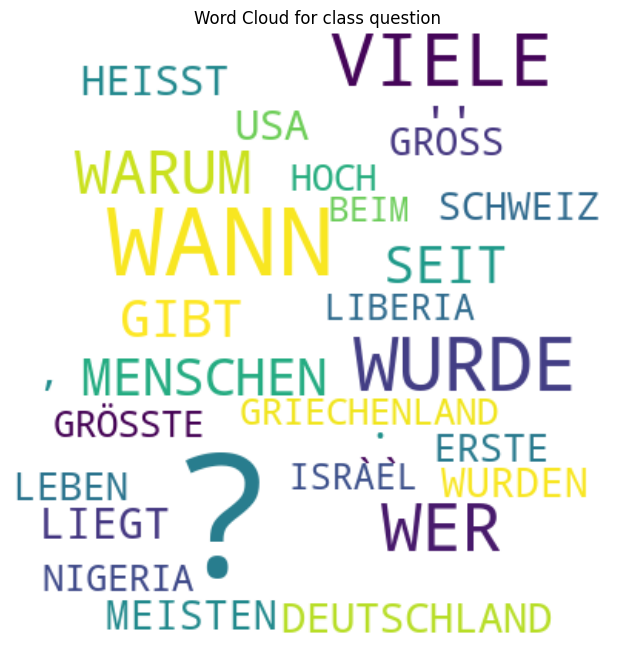

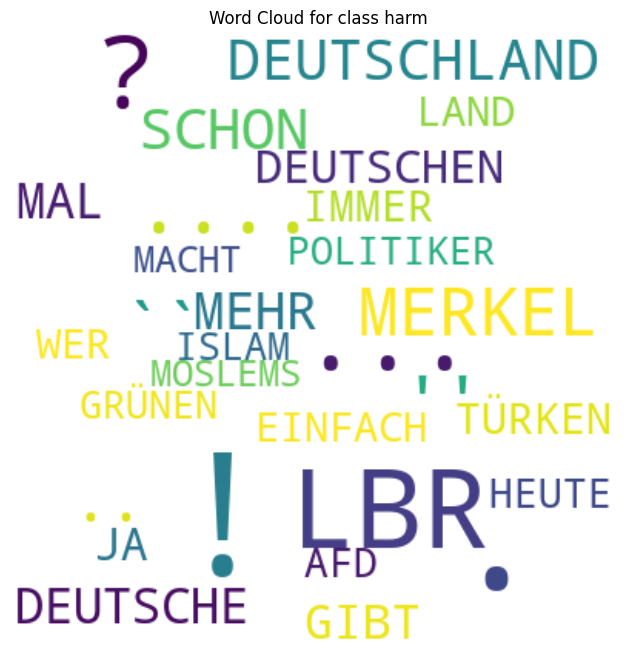

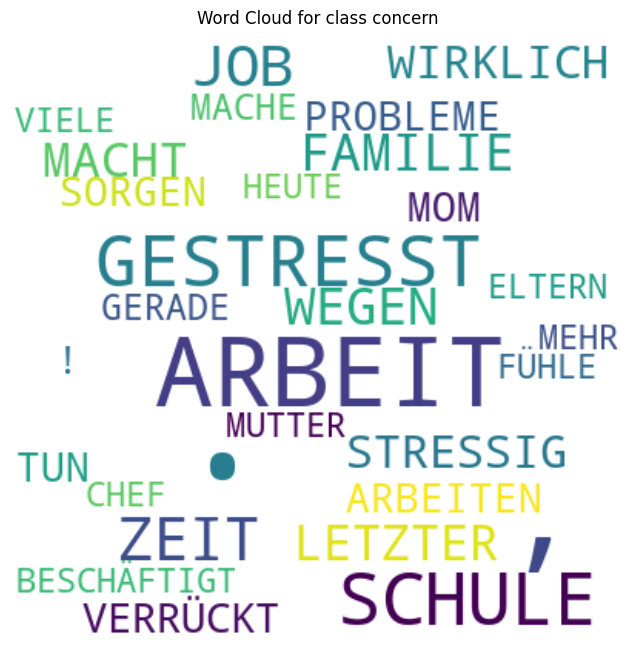

In [80]:
def generate_count_wordclouds(df:pd.DataFrame, top_n_words=50, tokenizer=word_tokenize):
    df = df.copy()
    
    # Erstellen des Tfidf Vectorizers, unter Ausschluss der deutschen Stop-Wörter
    vectorizer = TfidfVectorizer(use_idf=False, norm='l1', stop_words=stopwords.words('german'), tokenizer=tokenizer)
    
    labels = df['label'].unique()

    for label in labels:
        class_data = df[df['label'] == label]
        text_data = class_data['text']
        
        # Anwenden des Tfidf Vectorizers
        word_count_vector = vectorizer.fit_transform(text_data)
        sum_words = word_count_vector.sum(axis=0)
        
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        
        # Auswahl der Top-N-Wörter
        top_words_dict = {k.upper(): v for k, v in words_freq[:top_n_words]}
        
        wordcloud = WordCloud(
            width=400,
            height=400,
            random_state=21,
            max_font_size=110,
            background_color='white',
            prefer_horizontal=1,
        ).generate_from_frequencies(top_words_dict)
        
        plt.figure(figsize=(15, 8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Word Cloud for class {label}')
        plt.show()

generate_count_wordclouds(df_train, 30)

Anhand der wordclouds lässt sich erkennen, dass in der Klasse `question` häufig Fragewörter verwendet wurden.<br>
Auch das Fragezeichen ist ein wichtiger Indikator auf eine Frage. Allerdings ist es möglich, dass das Modell sich auf dieses Overfitted.<br>

Bei der Klasse `harm` kann man öfters Wörter im Bezug auf Politik (Merkel, Linke, Grüne, Politiker usw) und Beleidigungen (Hurensohn, Scheiss, usw).<br>

Bei der Klasse `concern` kommen öfters Wörter im Zusammenhang mit Schule vor sowie Wörter, welche sich auf Stress und Angst beziehen.

## Topic modelling

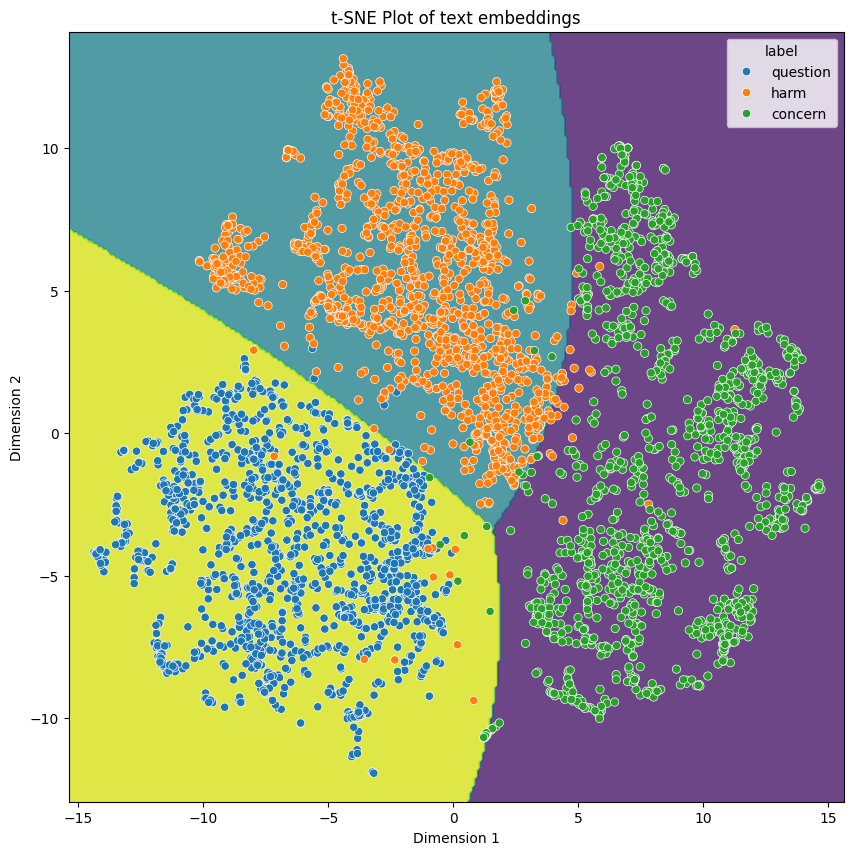

Number of wrong predictions:  85


In [81]:
def tsne_reduction(df:pd.DataFrame, pca_dim=50, perplexity=30, learning_rate=200, seed=1234):
    #make a copy
    df = df.copy()

    #create embeddings
    embeddings = np.array(HuggingFaceEmbeddings(model_name="sentence-transformers/distiluse-base-multilingual-cased-v1").embed_documents(df.text.to_list()))

    # Cimensionality reduction
    pca = PCA(n_components=pca_dim, random_state=seed)
    pca_result = pca.fit_transform(embeddings)
    
    # applyt-SNE
    tsne = TSNE(perplexity=perplexity, learning_rate=learning_rate, n_iter=300, random_state=seed)
    tsne_result = tsne.fit_transform(pca_result)

    #only select dim1 and dim2
    df[["dim1", "dim2"]] = tsne_result[:, :2]

    # apply QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(tsne_result, df.label)  # assuming df has a column named 'label' containing the class labels
    qda_classes = qda.predict(tsne_result)
    
    # add QDA classes to dataframe
    df['qda_class'] = qda_classes

    # Create mesh
    x_min, x_max = df['dim1'].min() - 1, df['dim1'].max() + 1
    y_min, y_max = df['dim2'].min() - 1, df['dim2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict mesh and convert labels to numeric
    Z = LabelEncoder().fit_transform(qda.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    return df, (xx, yy, Z)

df, (xx, yy, Z) = tsne_reduction(df_train)

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df, x="dim1", y="dim2", hue="label")
plt.title('t-SNE Plot of text embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

print("Number of wrong predictions: ", (df.label != df.qda_class).sum())

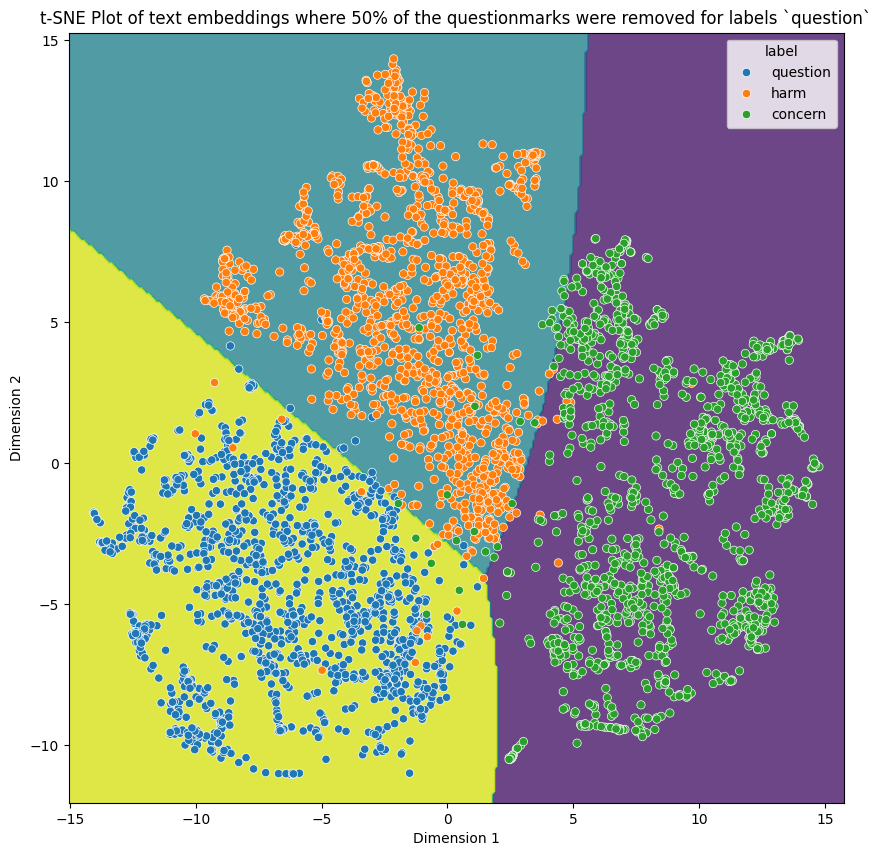

Number of wrong predictions:  69


In [82]:
df_train_questionmark_reduced = df_train.copy()

# delete 50% of the questionmarks from the questions
question_rows = df_train_questionmark_reduced[df_train_questionmark_reduced['label'] == "question"]
random_selection = question_rows.sample(frac=0.5, random_state=1)
df_train_questionmark_reduced.loc[random_selection.index, 'text'] = random_selection['text'].str.replace('?', '')

df, (xx, yy, Z) = tsne_reduction(df_train_questionmark_reduced)

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df, x="dim1", y="dim2", hue="label")
plt.title('t-SNE Plot of text embeddings where 50% of the questionmarks were removed for labels `question`')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

print("Number of wrong predictions: ", (df.label != df.qda_class).sum())

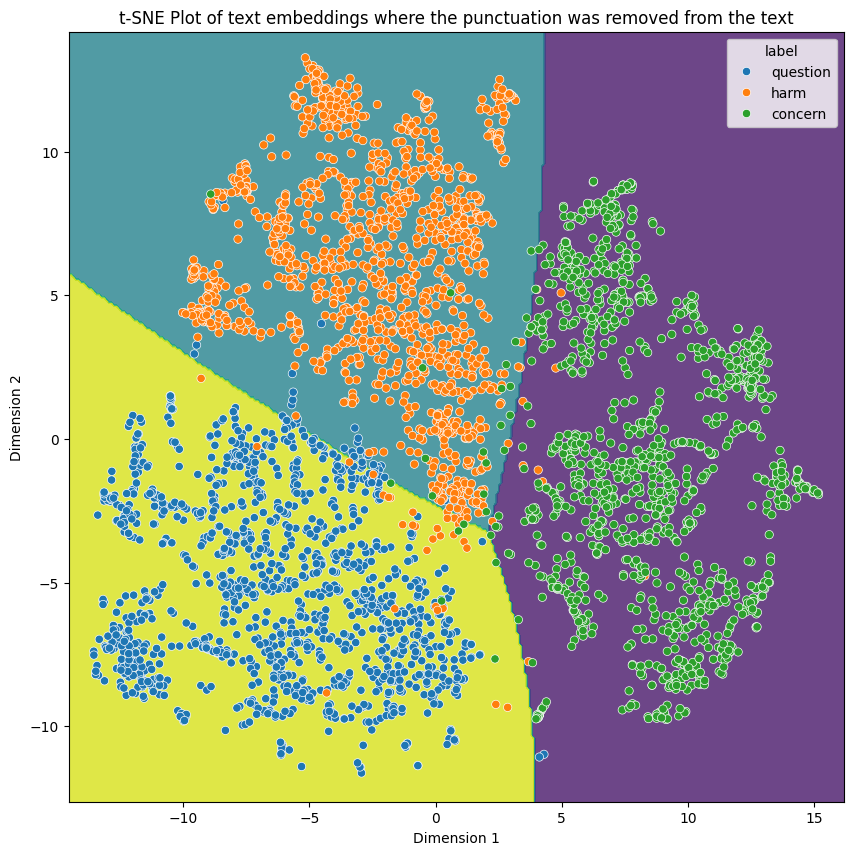

Number of wrong predictions:  102


In [83]:
df_train_no_punktuation = df_train.copy()
df_train_no_punktuation['text'] = df_train_no_punktuation['text'].str.replace(r'[^\w\s]', '', regex=True)

df, (xx, yy, Z) = tsne_reduction(df_train_no_punktuation)

# plot
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, alpha=0.8)
sns.scatterplot(df, x="dim1", y="dim2", hue="label")
plt.title('t-SNE Plot of text embeddings where the punctuation was removed from the text')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

print("Number of wrong predictions: ", (df.label != df.qda_class).sum())

# Model

## Architecture & Theory

https://anandsarank.medium.com/cnn-with-lstm-for-text-classification-53d18e5f7f5c

Architekturbeschreibung & Theorie

## Why to choose this Model

Weshalb wurde dieses Modell gewählt

## Implementation

In [84]:
class CNNLSTMModel(pl.LightningModule):    
    def __init__(self, vocab_size:int, embedding_size:int, num_filters:int, hidden_size:int, classes:list, learning_rate:float=1e-4):
        super().__init__()

        self.learning_rate = learning_rate
        self.classes = classes

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.conv1d = nn.Conv1d(in_channels=embedding_size, out_channels=num_filters, kernel_size=3, padding=1)  # 'same' padding
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_size, batch_first=True) # The number of expected features in the input x is set to the number of out_channels from Conv1D
        self.dense = nn.Linear(in_features=hidden_size, out_features=len(self.classes))

        self.save_hyperparameters()

    def forward(self, x, attention_mask=None):
        x = self.embedding(x) #embed tokens
        x = x.permute(0, 2, 1) #change order of dimensions for conv
        x = self.conv1d(x) #apply conv
        x = F.leaky_relu(x) #apply non linearity
        x = x.permute(0, 2, 1) #change order for lstm

        #prepare x for lstm if attention_mask != None
        if attention_mask is not None:
            # calculate the length of each sequence in the batch
            seq_lengths = attention_mask.sum(dim=1)
            # pack the sequences
            x = pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
            
        x, _ = self.lstm(x) #apply lstm

        #if packed sequence -> unpack
        if attention_mask is not None:
            x, seq_lengths = pad_packed_sequence(x, batch_first=True) # unpack sequence
            seq_lengths = seq_lengths.unsqueeze(-1).to(x.device) #reshape

            x = torch.sum(x, dim=1) / seq_lengths # global average pooling

        else:
            x = torch.mean(x, dim=1)  # global average pooling

        x = self.dense(x) #final dense layer

        return x #return logits
 
    def training_step(self, batch, batch_idx):
        # Extrahieren Sie die Eingaben, Labels und die Attention Mask aus dem Batch
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        # Rufen Sie die Methode forward auf, um die Logits zu erhalten
        logits = self.forward(inputs, attention_mask)

        loss = F.cross_entropy(logits, targets)
        
        # Optional: Loggen Sie den Trainingsverlust
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        logits = self(inputs, attention_mask)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, targets)
        acc = balanced_accuracy_score(targets.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(targets.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1_macro', f1_macro, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs = batch['input_ids']
        targets = batch['labels'].long()
        attention_mask = batch['attention_mask']

        logits = self(inputs, attention_mask)
        probas = logits.softmax(dim=1)
        preds = logits.argmax(dim=1)

        loss = F.cross_entropy(logits, targets)
        acc = balanced_accuracy_score(targets.cpu().tolist(), preds.cpu().tolist())
        f1_macro = f1_score(targets.cpu().tolist(), preds.cpu().tolist(), average="macro")

        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1_macro', f1_macro, prog_bar=True)

        return {"preds": preds, "probas": probas}

    def predict(self, text:str, tokenizer:BertTokenizerFast, max_token_length:int=512):
        tokenized = tokenizer(
            [text],
            truncation=True,
            padding=False,
            max_length=max_token_length,
            return_tensors="pt",
            add_special_tokens=False #remove special tokens

        )['input_ids'].to(self.device) #tokenize text and send to device

        pred = self(tokenized, None).argmax(dim=1)[0] #predict class

        return self.classes[pred] #map number to label
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

class ConfusionMatrixLogger(pl.Callback):
    def __init__(self) -> None:
        super().__init__()

        self.preds = []
        self.probas = []
        self.targets = []

    def on_test_batch_end(self, trainer, pl_module:CNNLSTMModel, outputs, batch, batch_idx) -> None:
        preds = outputs["preds"]
        probas = outputs["probas"]
        targets = batch['labels']

        self.preds.extend(preds.cpu().tolist())
        self.probas.extend(probas.cpu().tolist())
        self.targets.extend(targets.cpu().tolist())

    def on_test_epoch_end(self, trainer, pl_module:CNNLSTMModel):
        # Log the confusion matrix
        wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
            preds=self.preds, y_true=self.targets, class_names=pl_module.classes)
        })

        # Log the roc curve
        wandb.log({"roc_curve": wandb.plot.roc_curve(
            y_probas=self.probas, y_true=self.targets, labels=pl_module.classes)
        })

        # Clear for the next epoch
        self.preds = []
        self.probas = []
        self.targets = []

# Training

## Data loading

Theorie und wiso

## Implementation

In [85]:
class TextClassificationDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, tokenizer:BertTokenizerFast, text_col:str="text", label_col:str="label", max_length:int=128):
        self.tokenizer = tokenizer #store tokenizer
        self.data = dataframe #copy dataframe
        self.max_length = max_length #max token count
        self.text_col = text_col #store text col
        self.label_col = label_col #store label col
        self.label_encoder = LabelEncoder().fit(self.data[self.label_col]) #create and fit label encoder

        self.encode_labels()
        self.tokenize_text()
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()} #get respective entry from input_ids, token_type_ids, attention_mask
        item['labels'] = self.labels[idx] #add label
        return item

    def __len__(self):
        return len(self.labels)

    def tokenize_text(self):
        #tokenize text
        self.encodings = self.tokenizer(
            list(self.data[self.text_col]), 
            truncation=True, 
            padding=True, 
            max_length=self.max_length, 
            return_tensors="pt",
            add_special_tokens=False #remove special tokens
        )

    def encode_labels(self):
        #encode labels
        self.labels = torch.tensor(self.label_encoder.transform(self.data[self.label_col]))

    def dataset_from_self(self, dataframe:pd.DataFrame):
        copy_dataset = copy(self) #create a copy of itself

        copy_dataset.data = dataframe #override data
        copy_dataset.tokenize_text() #tokenize new text
        copy_dataset.encode_labels() #encode new labels

        return copy_dataset

    @staticmethod
    def stratified_random_sampling(dataframe:pd.DataFrame, train_size:float, ref_col:str, seed:int=None):
        # Stellen Sie sicher, dass train_size einen gültigen Wert hat
        if not 0 < train_size < 1:
            raise ValueError("train_size must be between 0 and 1")
        
        # Gruppieren des DataFrames nach der Referenzspalte und Anwenden der Sample-Methode auf jede Gruppe, Entfernen der zusätzlichen Indexebene, die durch groupby erzeugt wird
        train_df = dataframe.groupby(ref_col).apply(lambda x: x.sample(frac=train_size, random_state=seed)).reset_index(ref_col, drop=True, inplace=False)
        
        # Finden der Indexe, die nicht in der Trainingsstichprobe ausgewählt wurden
        val_idx = dataframe.index.difference(train_df.index)
        
        # Erstellen des Validierungs-DataFrames
        val_df = dataframe.loc[val_idx]
        
        return (train_df.reset_index(drop=True, inplace=False), val_df.reset_index(drop=True, inplace=False))

## Overfit with all punctuations

In [86]:
#load train dataset
df_train = pd.read_parquet("data/train.parquet")
df_train, df_val = TextClassificationDataset.stratified_random_sampling(df_train, 0.8, "label", 1234)
df_test = pd.read_parquet("data/test.parquet")

#tokenizer
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-german-cased")

#Dataset and loader
train_set = TextClassificationDataset(df_train, tokenizer)
val_set = train_set.dataset_from_self(df_val)
test_set = train_set.dataset_from_self(df_test)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=len(val_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))

PARAMS = {
    "vocab_size": len(train_set.tokenizer.vocab),
    "classes": train_set.label_encoder.classes_,
    "embedding_size": 256,
    "num_filters": 128,
    "hidden_size": 64,
    "learning_rate": 1e-5
}

model = CNNLSTMModel(**PARAMS)

logger = WandbLogger(entity="t_buess", project="chatbot-classification", log_model=True, notes="Overfit with all punctuations")
logger.watch(model, log="all")

#callbacks definitions
#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=True, mode="min")
conf_matrix_callback = ConfusionMatrixLogger()

trainer = Trainer(devices=1, accelerator="gpu", logger=logger, log_every_n_steps=4, max_epochs=50, callbacks=[conf_matrix_callback])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(dataloaders=test_loader)

wandb.finish()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 8.0 M 
1 | conv1d    | Conv1d    | 98.4 K
2 | lstm      | LSTM      | 49.7 K
3 | dense     | Linear    | 195   
----------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.442    Total estimated model params size (MB)


c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 102/102 [00:00<00:00, 193.61it/s, v_num=reg3, val_loss=0.145, val_acc=0.944, val_f1_macro=0.944]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 102/102 [00:00<00:00, 150.53it/s, v_num=reg3, val_loss=0.145, val_acc=0.944, val_f1_macro=0.944]


c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at .\chatbot-classification\9ulrreg3\checkpoints\epoch=49-step=5100.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\chatbot-classification\9ulrreg3\checkpoints\epoch=49-step=5100.ckpt
c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoade

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9398422090729784
      test_f1_macro         0.9399048475405941
        test_loss           0.16992856562137604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_f1_macro,▁
test_loss,▁
train_loss,████▇▇▆▅▅▅▄▃▃▂▃▃▃▂▃▂▁▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▄▆████████████████████████████████████
val_f1_macro,▁▃▅▆████████████████████████████████████
val_loss,████▇▆▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_acc,0.93984


artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification/model-0agszp20:best").download()
model = CNNLSTMModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

print(model.predict("Es geht mir schlecht...", tokenizer))
print(model.predict("Ich weiss nicht mehr was ich machen soll...", tokenizer))
print(model.predict("Welcher Hurensohn unterrichtet pra?", tokenizer))

# Overfit where 80% from the texts the punctuations are removed

In [87]:
remove_punctuation_percent = 80 #remove punctuation at x percent of the observations

#load train dataset
df_train = pd.read_parquet("data/train.parquet")

# Funktion, um Satzzeichen aus einem Text zu entfernen
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

# Für jedes einzigartige Label 50% der Daten auswählen und Satzzeichen entfernen
for label in df_train['label'].unique():
    # Filtere das DataFrame nach dem aktuellen Label
    sub_df = df_train[df_train['label'] == label]
    
    # Wähle 80% der Zeilen aus (zufällig)
    indices_to_modify = sub_df.sample(frac=0.8, random_state=1234).index
    
    # Entferne Satzzeichen für ausgewählte Zeilen
    df_train.loc[indices_to_modify, 'text'] = df_train.loc[indices_to_modify, 'text'].apply(remove_punctuation)

print("Train data Anzahl Observationen mit und ohne Satzzeichen:")
display(df_train.text.apply(lambda x: any(p in x for p in string.punctuation)).groupby(df_train.label).value_counts())

df_train, df_val = TextClassificationDataset.stratified_random_sampling(df_train, 0.8, "label", 1234)
df_test = pd.read_parquet("data/test.parquet")

#tokenizer
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-german-cased")

#Dataset and loader
train_set = TextClassificationDataset(df_train, tokenizer)
val_set = train_set.dataset_from_self(df_val)
test_set = train_set.dataset_from_self(df_test)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=len(val_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))

PARAMS = {
    "vocab_size": len(train_set.tokenizer.vocab),
    "classes": train_set.label_encoder.classes_,
    "embedding_size": 256,
    "num_filters": 128,
    "hidden_size": 64,
    "learning_rate": 1e-5
}

model = CNNLSTMModel(**PARAMS)

logger = WandbLogger(entity="t_buess", project="chatbot-classification", log_model=True, notes=f"Overfit where 80% from the texts the punctuations are removed")
logger.watch(model, log="all")

#callbacks definitions
#early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=True, mode="min")
conf_matrix_callback = ConfusionMatrixLogger()

trainer = Trainer(devices=1, accelerator="gpu", logger=logger, log_every_n_steps=4, max_epochs=50, callbacks=[conf_matrix_callback])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(dataloaders=test_loader)

wandb.finish()

Train data Anzahl Observationen mit und ohne Satzzeichen:


label     text 
concern   False    1094
          True      256
harm      False    1109
          True      241
question  False    1080
          True      270
Name: count, dtype: int64

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 8.0 M 
1 | conv1d    | Conv1d    | 98.4 K
2 | lstm      | LSTM      | 49.7 K
3 | dense     | Linear    | 195   
----------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.442    Total estimated model params size (MB)


c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 102/102 [00:00<00:00, 197.38it/s, v_num=859f, val_loss=0.247, val_acc=0.923, val_f1_macro=0.922]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 102/102 [00:00<00:00, 153.75it/s, v_num=859f, val_loss=0.247, val_acc=0.923, val_f1_macro=0.922]


c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at .\chatbot-classification\ju8b859f\checkpoints\epoch=49-step=5100.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\chatbot-classification\ju8b859f\checkpoints\epoch=49-step=5100.ckpt
c:\Users\Stephan\anaconda3\envs\chatbot-text_classification\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoade

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9013806706114398
      test_f1_macro         0.9014628781077415
        test_loss           0.30495643615722656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_f1_macro,▁
test_loss,▁
train_loss,█████▇▆▆▆▅▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▂▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▁▂▃▅▆▇▇▇███████████████████████████████
val_f1_macro,▁▁▂▃▆▇▇▇████████████████████████████████
val_loss,████▇▇▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
test_acc,0.90138


artifact_dir = wandb.Api().artifact("t_buess/chatbot-classification/model-dnvg492x:best").download()
model = CNNLSTMModel.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

print(model.predict("Es geht mir schlecht...", tokenizer))
print(model.predict("Ich weiss nicht mehr was ich machen soll...", tokenizer))
print(model.predict("Wieviele LE's gibt es im Modul PRA?", tokenizer))